# Trackpy-force
This tutorial notebook shows an example in which we extract forces from the trajectories of Brownian particles, using three different methods. More background information can be found in my thesis, chapter 3:

- Casper van der Wel, 'Lipid mediated colloidal interactions', Chapter 3 'Force measurement from sparse trajectories in curved geometries', Casimir PhD Series, Delft-Leiden, 2017-27, ISBN 978-90-8593-311-3, available at [openaccess.leidenuniv.nl](http://openaccess.leidenuniv.nl) (or [here](http://caspervdwel.nl/thesis.pdf))

The codebase is available on https://github.com/caspervdw/trackpy-force

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tpforce

## Generate artificial trajectories
Using a known force, we simulate 100 time steps. The simulation involves 1000 (non-interacting) Brownian particles in a radial force field. The force points either away or towards the origin. The simulation itself is not the purpose of this tutorial, it is merely a tool to test if we can recover the original force.

In [2]:
def run_2D_radial_sim(force_func, n_particles, n_steps, D, dt, dt_sim,
                      initial_radius=6, initial_pos=None):
    from scipy.stats import norm as normal_distribution
    x, y = np.empty((2, n_steps, n_particles))

    if initial_pos is None:
        # random numbers in circle of radius 6
        x0 = np.random.random(n_particles * 2) * (initial_radius * 2) - initial_radius
        y0 = np.random.random(n_particles * 2) * (initial_radius * 2) - initial_radius

        mask = x0**2 + y0**2 < initial_radius**2   
        x[0] = x0[mask][:n_particles]
        y[0] = y0[mask][:n_particles]
    else:
        x0, y0 = initial_pos
        assert len(x0) == len(y0)
        mask = np.random.choice(np.arange(len(x0)), n_particles, replace=False)
        x[0] = x0[mask]
        y[0] = y0[mask]

    # this simulation is valid when F and D are constant locally

    dilution = int(dt // dt_sim)
    n_steps_sim = n_steps * dilution

    rv = normal_distribution(loc=0., scale=(2*D*dt_sim)**0.5)

    x_curr = x[0].copy()
    y_curr = y[0].copy()
    for i in range(1, n_steps_sim):
        r_curr = np.sqrt(x_curr**2 + y_curr**2)
        force = force_func(r_curr)
        force_x = force * (x_curr / r_curr)
        force_x[~np.isfinite(force_x)] = 0.
        force_y = force * (y_curr / r_curr)
        force_y[~np.isfinite(force_y)] = 0.

        dx, dy = rv.rvs((2, n_particles))

        # the mean of the distribution displaces by gamma * F * dt
        # F is in units of kT/um, so gamma = D / kT = D
        x_curr += dx + force_x * D * dt_sim
        y_curr += dy + force_y * D * dt_sim
        if i % dilution == 0:
            x[i // dilution] = x_curr
            y[i // dilution] = y_curr
            
    return x, y

x_plot = np.arange(0, 6.1, 0.1)
energy_func = lambda r: (r**4 - 20 * r**2) / 50  # kT
force_func = lambda r: (4*r**3 - 40 * r) / -50   # kT / um

x, y = run_2D_radial_sim(force_func, n_particles=1000,
                         n_steps=100, D=0.5, dt=0.1, dt_sim=0.01, initial_radius=6)

The simulation has generated `1000` trajectories with a length of `100`. The initial positions of these trajectories are uniformly distributed in a circle with radius `6`. We plot the `10` trajectories to provide an idea of the contents of the position variables `x` and `y`, as well as the shape of the radial potential energy field:

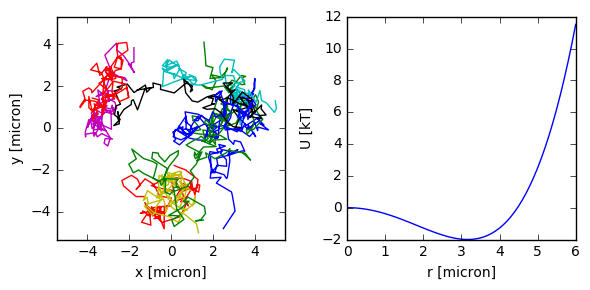

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.plot(x[:, ::100], y[:, ::100]);
ax1.axis('equal')
ax1.set_xlabel('x [micron]')
ax1.set_ylabel('y [micron]')

ax2.plot(x_plot, energy_func(x_plot))
ax2.set_xlabel('r [micron]')
ax2.set_ylabel('U [kT]')

plt.tight_layout()

# Analyze using a histogram
Now we have our artificial data setup in `x` and `y`, we will try to extract the radial potential energy field. The negative gradient of this will be our force field.

The will cover three methods, of which the first involves simply histogramming the end positions of the particles. In this first method, we make the central assumption that the particles have equilibrated inside the potential field so that:

$U = - k_B T \ln{\rho}$

Where $U$ is the energy, $k_B T$ the thermal energy, and $\rho$ the probability density.

When measuring interactions between pairs of particles, this method is the same as the 'pair correlation' or 'radial distribution function' $g(r)$.

First we take the histogram of the initial positions, which yield a flat energy profile, as we started with a uniform distribution in our simulation. Then we do the same for the final positions of all the particles, which (if particles have equilibrated) should match the input potential.

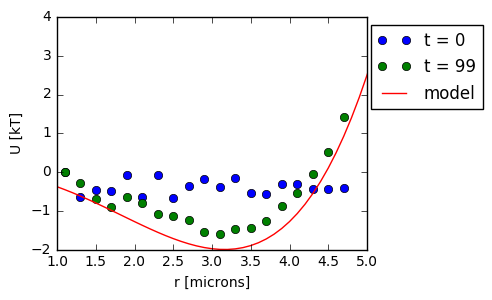

In [4]:
def compute_histogram(x, y, start, stop, bw):
    bins = np.arange(start, stop, bw)
    centers = (bins[1:] + bins[:-1]) / 2
    r = np.sqrt(x**2 + y**2).ravel()
    bin_area = 2 * np.pi * r * bw
    rho, _ = np.histogram(r, bins=bins, weights=1/bin_area)
    rho = rho / len(r)    

    energy = - np.log(rho)
    energy -= energy[0]
    return centers, energy

fig, ax1 = plt.subplots(1, 1, figsize=(4, 3))
for t in [0, 99]:
    centers, energy = compute_histogram(x[t], y[t], 1, 5, 0.2)
    ax1.plot(centers, energy, label='t = {}'.format(t),
             marker='o', ls='None')

ax1.plot(x_plot, energy_func(x_plot), label='model')
ax1.legend(bbox_to_anchor=[1.4, 1])
ax1.set_xlabel('r [microns]')
ax1.set_ylabel('U [kT]')
ax1.set_xlim(1, 5)
ax1.set_ylim(-2, 4);

The energy well that we put into the simulation indeed more ore less comes out of our analysis, given long enough simulation time. However, we here only made use of the positions in 1 of the 100 time steps in the simulation. This raises the question: can we do better making use of all 100 timesteps?

# Displacement sampling

Instead of analyzing the end positions of the particles, we look at the particle displacements. We basically compare all `{x, y}` at `t` with all `{x, y}` at `t + dt`, with `dt` an arbitrary sampling time. There are optimal values for this sampling time, but we will not consider this question now and jump right into the analysis.

In [5]:
x_t0 = x[:-1].ravel()
x_t1 = x[1:].ravel()
y_t0 = y[:-1].ravel()
y_t1 = y[1:].ravel()

# make two (N, M) arrays with N the number of observations and M the number of dimensions (2)
data_t0 = np.array([x_t0, y_t0]).T
data_t1 = np.array([x_t1, y_t1]).T

print(data_t0.shape, data_t1.shape)

(99000, 2) (99000, 2)


# Maximum likelihood estimation

Now, we try to find the (radial) force that best fits the observed displacements. We do this by considering that the probability of observing a single 'transition' from `x0` to `x1` is (approximately) given by the following Gaussian:


$$P_\tau (x_1 | x_0) = \frac{1}{2 \sqrt{\pi D \tau}} \exp{-\frac{(x_1 - x_0 - \beta F(x_0) D \tau)^2}{4 D \tau}}$$

Where $P_\tau$ is the transition probability at sampling time $\tau$, $D$ the diffusion constant, and $F$ the (local) force. So then the probability of observing a collection of transitions is just the product of the individual ones:

$$\mathcal{L}(\{x\} | D, F_j) = \sum_{j=1}^N \log P_\tau (x_j | x_{j+1}, D, F_j)$$

Here, we took a logarithm which turned the product into a sum, and defined the log-likelihood $\mathcal{L}$. The values of $D$ and $F(x_j)$ that maximize this probability are the maximimum likelihood estimates that we are looking for.

Trackpy-force (`tpforce`) presents a framework for doing this analysis. It however does not do everything for you: you have to come up with some model for the force and diffusivity, that may depend on a number of parameters.

So, we have to setup a certain model that provides a diffusion constant $D$ and force $F$ for every initial position $x_0$, depending on parameters, which will be found by the optimizer.

There are some built-in model classes like `ConstantDrift1D`, `PiecewiseForce1D`, and `PiecewiseEnergy2DGrid`, but we will build here one ourself specific to the radial force simulation done above. See comments below in the code.

In [6]:
# derive the model class from the MLE (Max Likelihood Estimation) baseclass from tpforce
class PiecewiseRadialForce(tpforce.MLEBase):
    # the base class does some work for us, but we have to define the model parameters.
    # In this example, we pretend to already know the diffusion constant D, but that we
    # do not know the force. We do assume the force to be always directed radially.
    # To model the force, we define a list of values in radial direction to get a 
    # piecewise interpolated function for the force.
    def initialize(self, force_r, D):
        # store the values that define the model
        self.force_r = force_r
        self.D = D        

        # the data is already stored as two arrays of shape (N, M),
        # with N the number of observations and M the number of dimensions (2)
        xy_t0, xy_t1 = self.measurements

        # compute the radial positions: the force will depend on it
        r_t0 = np.sqrt(xy_t0[:, 0]**2 + xy_t0[:, 1]**2)    

        # filter the data so that all falls inside the piecewise interpolated force
        mask = (r_t0 >= force_r[0]) & (r_t0 <= force_r[-1])
        xy_t0 = xy_t0[mask]
        xy_t1 = xy_t1[mask]
        r_t0 = r_t0[mask]
        
        # store the masked data
        self.measurements = (xy_t0, xy_t1)

        # compute the unit vectors giving the directions of the forces
        # for each initial position
        self.force_vect = np.array([xy_t0[:, 0] / r_t0,
                                    xy_t0[:, 1] / r_t0]).T

        # initialize the piecewise interpolating function 
        self.force_func = tpforce.Piecewise1D(self.force_r, r_t0)

    @property
    def n_params(self):
        return len(self.force_r)

    @property
    def model_bounds(self):
        # define the bounds for each parameter: in our case, the force at each
        # r can be any value so we return the empty boundary [None, None] for each
        # parameter
        return [[None, None]] * len(self.force_r)

    @property
    def default_p0(self):
        # define the initial value for each parameter: this will be the first guess
        # for the optimizer that will find the MLE of each parameter
        return np.zeros(len(self.force_r))

    
    # The following to method will compute diffusion constants (D) and force vectors (F)
    # for each datapoint, given a the model. In our case, the model is as follows:
    # - D is simply a constant value
    # - F follows from piecewise interpolation on the grid `force_r`
    # Put the operations that are  not dependent on the model parameters all in
    # `initialize` for the shortest computation time.
    def model_compute(self, p):
        force_func = self.force_func
        force_vect = self.force_vect
        Dt = self.D * self.tau
        force = force_func(p)[:, np.newaxis] * force_vect * Dt / self.kT
        # it is expected that this method returns (force, diffusion coefficient).
        # different shapes are allowed, which are documented in the docstrings.
        return force, Dt

Having defined the model, we construct the estimator using the sampled displacement data. Also, we decide on a grid on which to interpolate the force. Then we do some checks to understand the estimator.

In [7]:
force_grid = np.arange(1, 5, 0.2)
estimator = PiecewiseRadialForce(data_t0, data_t1,
                                 force_r=force_grid, D=0.5,
                                 tau=0.1, kT=1.)


print('Number of observations: {}'.format(estimator.N))
print('Number of dimensions: {}'.format(estimator.M))
print('Shape of the two observation arrays: {} and {}'.format(estimator.measurements[0].shape, estimator.measurements[1].shape))
print('Shape of the force unit vector array: {}'.format(estimator.force_vect.shape))
print('Shape of the default parameter array: {}'.format(estimator.default_p0.shape))
print('Shape of the result of the force_func: {}'.format(estimator.force_func(estimator.default_p0).shape))

Number of observations: 95812
Number of dimensions: 2
Shape of the two observation arrays: (95812, 2) and (95812, 2)
Shape of the force unit vector array: (95812, 2)
Shape of the default parameter array: (20,)
Shape of the result of the force_func: (95812,)


The maximum likelihood estimate of the model parameters is found using the `fit` method. The `fit` method repeatedly calls `model_compute` and finds the model parameter values that gives the largest (log) likelihood.

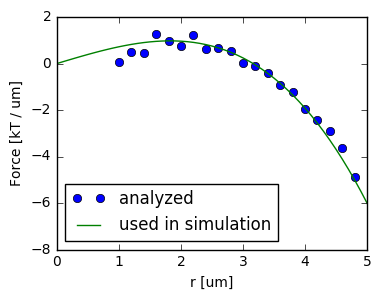

In [8]:
result = estimator.fit()
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(force_grid, result, marker='o', ls='None', label='analyzed')
ax.plot(x_plot, force_func(x_plot), label='used in simulation')
ax.legend(loc='lower left')
ax.set_xlim(0, 5)
ax.set_ylim(-8, 2)
ax.set_xlabel('r [um]')
ax.set_ylabel('Force [kT / um]');

To obtain the energy, we could now integrate the (negative) force, choosing a reference value for the energy.

## Using larger displacements

We check the method for increasing values of sampling time `dt` ($\tau$). To save some time, we reduce the number of simulation steps and increase the number of particles. Not that this does not decrease the number of measurements! We make sure that the time step for the simulation is at least 0.1 seconds.

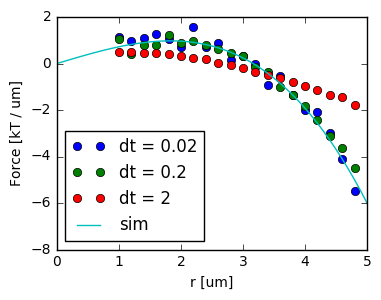

In [9]:
force_grid = np.arange(1, 5, 0.2)
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

for dt in [0.02, 0.2, 2]:
    x_this, y_this = run_2D_radial_sim(force_func, n_particles=10000,
                                       n_steps=10, D=0.5,
                                       dt=dt, dt_sim=min(dt, 0.1),
                                       initial_radius=6)
    
    _data_t0 = np.array([x_this[:-1].ravel(), y_this[:-1].ravel()]).T
    _data_t1 = np.array([x_this[1:].ravel(), y_this[1:].ravel()]).T
    estimator = PiecewiseRadialForce(_data_t0, _data_t1,
                                     force_r=force_grid, D=0.5,
                                     tau=dt, kT=1.)
    result = estimator.fit()
    ax.plot(force_grid, result, marker='o', ls='None',
            label='dt = {}'.format(dt))
    
ax.plot(x_plot, force_func(x_plot), label='sim')
ax.legend(loc='lower left')
ax.set_xlim(0, 5)
ax.set_ylim(-8, 2)
ax.set_xlabel('r [um]')
ax.set_ylabel('Force [kT / um]');

We note two effects: the results become more noisy for very small `dt`, but inaccurate at very large `dt`. The explanation of this effect can be found in my thesis. In short: the measurements become less precise at low dt because diffusive effects then dominate over force effects. This is a fundamental limit to this measurement. The measurements become less accurate at high dt because the particle traverses a large part of the energy potential landscape in that time, so that we cannot just use $F(x_0)$ to model the force experienced by the particle in `dt`.

In other words, for large `dt`, we need a better model for the transition probability $P_\tau$ that accounts (at least) for gradients in the force. Analytical forms of $P_\tau$ including force gradients are however very complex, therefore we will rely on a trick so that we do not have to assume a form for $P_\tau$ at all.

# Transition probability matrix

The transition probability gives $P_\tau$ the probability of finding a particle at $x_1$, giving the particle was at $x_0$ some time $\tau$ earlier. We can discritize this probability in $x_0$ and $x_1$, giving a square matrix that lists all the probabilities to observing transitions from $x_0$ and $x_1$.

The eigenvector of this matrix will be the stationary distribution, which is directly related to the energy landscape (assuming the diffusion constant is not dependent on `x`). See my thesis, Chapter 3 for a longer explanation.

The transition matrix can be computed through `tpforce.transition_matrix`. This function does some necessary mirroring tricks at the analysis boundaries. Then the stationary distribution can be computed using `tpforce.stationary`. This does not actually compute the eigenvector, but just multiplies the matrix with itself many times, which is more robust.

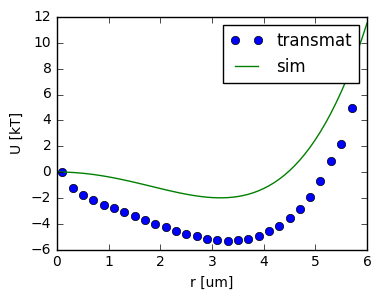

In [10]:
x_t0 = x[:-1].ravel()
x_t1 = x[1:].ravel()
y_t0 = y[:-1].ravel()
y_t1 = y[1:].ravel()

r_t0 = np.sqrt(x_t0**2 + y_t0**2)
r_t1 = np.sqrt(x_t1**2 + y_t1**2)
bins = np.arange(0, 6, 0.2)
bins, mat, freq = tpforce.transition_matrix(r_t0, r_t1, bins=bins)
rho = tpforce.stationary(mat)

centers = (bins[1:] + bins[:-1])/2
energy = - np.log(rho)
energy -= energy[0]

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(centers, energy, marker='o', ls='None', label='transmat')
ax.plot(x_plot, energy_func(x_plot), label='sim')
ax.set_xlabel('r [um]')
ax.set_ylabel('U [kT]')
ax.legend();

The result does not seem right. This is because we forgot one important thing: the geometry!

Any particle in 2D will have a higher chance to 'drift' from the origin than to 'drift' towards the origin. This is because the fact that the area of 'rings' of same `r` is increasing with `r`. If we consider the transition probability of `r` without thinking about this, the particles will seem to be repelled by the origin. Indeed we see this in our analysis (superimposed on the original potential).

We can correct for this by taking into account the Jacobian of the coordinate system. In this case:

$$J = \Big|\det \Big( \frac{dx dy}{dr d\theta} \Big) \Big| = r.$$

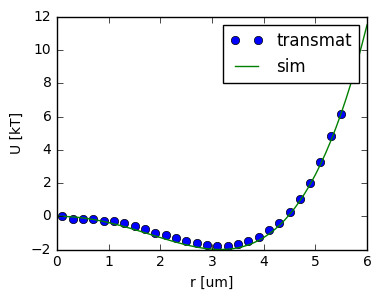

In [11]:
bins, mat, freq = tpforce.transition_matrix(r_t0, r_t1, bins=bins,
                                            jacobian=lambda x: x)
rho = tpforce.stationary(mat)

centers = (bins[1:] + bins[:-1])/2
energy = - np.log(rho)
energy -= energy[0]

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(centers, energy, marker='o', ls='None', label='transmat')
ax.plot(x_plot, energy_func(x_plot), label='sim')
ax.set_xlabel('r [um]')
ax.set_ylabel('U [kT]')
ax.legend();

This is much better. The measured energy still seems to be consistently larger than the simulation potential: this however has no meaning, only the gradient in energy has. Here, I set the reference energy at `r = 0`, however, this point is subject to large error as we observe only few particles there.

# Other functionality

- A simple Bayesian estimator is implemented for the MLE method and can be accessed through `estimator.sample_bayesian(...)`. For this, the `estimator.log_prior(...)` must be implemented, and also the Python package EMCEE needs to be installed.
- MLEBase can also estimate force fields in more than one dimension. Forces can be M-dimensional vectors, and Diffusion can be (M, M) tensors. There are two example base  classes implemented named `PiecewiseForce2DGrid` and ` PiecewiseEnergy2DGrid`. The first estimates a 2D force field, and the second a 2D energy field. As the second uses a gradient to compute the forces, it assumes the absence of curl (vorticity) in the force field.
- MLEBase allows a `postprocess(params)` method, that transforms the parameters into more sensible values. Useful for adding a reference point to potential fields, or for integrating force fields.

## About this work
This tutorial was written by Casper van der Wel, as part of his PhD thesis in Daniela Kraft’s group at the Huygens-Kamerlingh-Onnes laboratory, Institute of Physics, Leiden University, The Netherlands. This work was supported by the Netherlands Organisation for Scientific Research (NWO/OCW). 